# Neural Networks

An **artificial neural network** (or neural network for short) is a predictive model motivated by the way the brain operates. Think of the brain as a collection of neurons wired together. Each neuron looks at the outputs of the other neurons that feed into it, does a calculation, and then either fires (if the calculation exceeds some threshhold) or doesn’t (if it doesn’t).

Accordingly, artificial neural networks consist of artificial neurons, which perform similar calculations over their inputs. Neural networks can solve a wide variety of problems like handwriting recognition and face detection, and they are used heavily in `deep learning`, one of the trendiest subfields of data science. However, most neural networks are `“black boxes”` — inspecting their details doesn’t give you much understanding of how they’re solving a problem.

## Perceptron

Pretty much the simplest neural network is the **perceptron**, which approximates a sin‐ gle neuron with n binary inputs. It computes a weighted sum of its inputs and “fires” if that weighted sum is zero or greater.

In [1]:
from scratch.linear_algebra import Vector, dot

def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

In [2]:
def perceptron_output(weights: Vector, bias: float, x: Vector) -> float:
    """Returns 1 if the perceptron 'fires', 0 if not"""
    calculation = dot(weights, x) + bias
    return step_function(calculation)

With properly chosen weights, perceptrons can solve a number of simple problems. For example, we can create an `AND gate` (which returns 1 if both its inputs are 1 but returns 0 if one of its inputs is 0):

In [3]:
and_weights = [2., 2]
and_bias = -3.

assert perceptron_output(and_weights, and_bias, [1, 1]) == 1
assert perceptron_output(and_weights, and_bias, [0, 1]) == 0
assert perceptron_output(and_weights, and_bias, [1, 0]) == 0
assert perceptron_output(and_weights, and_bias, [0, 0]) == 0

Similarly, we could build an `OR gate`:

In [4]:
or_weights = [2., 2]
or_bias = -1.

assert perceptron_output(or_weights, or_bias, [1, 1]) == 1
assert perceptron_output(or_weights, or_bias, [0, 1]) == 1
assert perceptron_output(or_weights, or_bias, [1, 0]) == 1
assert perceptron_output(or_weights, or_bias, [0, 0]) == 0

And we could build a `NOT gate` (which has one input and converts 1 to 0 and 0 to 1):

In [5]:
not_weights = [-2.]
not_bias = 1.

assert perceptron_output(not_weights, not_bias, [0]) == 1
assert perceptron_output(not_weights, not_bias, [1]) == 0

<img src="images/neural_networks1.png" alt="" style="width: 600px;"/>


However, there are some problems that simply can’t be solved by a single perceptron. For example, no matter how hard you try, you cannot use a perceptron to build an `XOR gate` that outputs 1 if exactly one of its inputs is 1 and 0 otherwise. This is where we start needing more-complicated neural networks.

In [6]:
# XOR logic gate without artificial neurons
and_gate = min
or_gate = max
xor_gate = lambda x, y: 0 if x == y else 1

In [10]:
assert xor_gate(0, 1) == 1
assert xor_gate(1, 1) == 0
assert xor_gate(1, 0) == 1
assert xor_gate(0, 0) == 0

## Feed-Forward Neural Network

The topology of the brain is enormously complicated, so it’s common to approximate it with an idealized **feed-forward** neural network that consists of discrete layers of neurons, each connected to the next. This typically entails an `input layer` (which receives inputs and feeds them forward unchanged), one or more `“hidden layers”` (each of which consists of neurons that take the outputs of the previous layer, performs some calculation, and passes the result to the next layer), and an `output layer` (which produces the final outputs).

Just like the perceptron, each (noninput) neuron has a` weight` corresponding to each of its inputs and a `bias`. To make our representation simpler, we’ll add the bias to the end of our weights vector and give each neuron a bias input that always equals 1.

As with the `perceptron`, for each neuron we’ll sum up the products of its inputs and its weights. But here, rather than outputting the step_function applied to that prod‐ uct, we’ll output `a smooth approximation of the step function`. In particular, we’ll use the `sigmoid function`:

<img src="images/neural_networks2.png" alt="" style="width: 600px;"/>

See below for other activation functions.

In [11]:
import math

def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))

In [12]:
sigmoid(-5)

0.0066928509242848554

In [13]:
sigmoid(0)

0.5

In [14]:
sigmoid(2)

0.8807970779778823

Graph X readings: range(-20, 21)
Graph Y readings: [2.0611536181902037e-09, 5.602796406145941e-09, 1.522997951276035e-08, 4.1399375473943306e-08, 1.12535162055095e-07, 3.059022269256247e-07, 8.315280276641321e-07, 2.2603242979035746e-06, 6.144174602214718e-06, 1.670142184809518e-05, 4.5397868702434395e-05, 0.00012339457598623172, 0.0003353501304664781, 0.0009110511944006454, 0.0024726231566347743, 0.0066928509242848554, 0.01798620996209156, 0.04742587317756678, 0.11920292202211755, 0.2689414213699951, 0.5, 0.7310585786300049, 0.8807970779778823, 0.9525741268224334, 0.9820137900379085, 0.9933071490757153, 0.9975273768433653, 0.9990889488055994, 0.9996646498695336, 0.9998766054240137, 0.9999546021312976, 0.999983298578152, 0.9999938558253978, 0.999997739675702, 0.9999991684719722, 0.999999694097773, 0.9999998874648379, 0.9999999586006244, 0.9999999847700205, 0.9999999943972036, 0.9999999979388463]


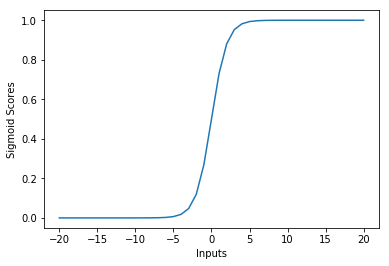

In [60]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def sigmoid(inputs):
    """
    Calculate the sigmoid for the give inputs (array)
    :param inputs:
    :return:
    """
    sigmoid_scores = [1 / float(1 + np.exp(- x)) for x in inputs]
    return sigmoid_scores


def line_graph(x, y, x_title, y_title):
    """
    Draw line graph with x and y values
    :param x:
    :param y:
    :param x_title:
    :param y_title:
    :return:
    """
    plt.plot(x, y)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.show()


graph_x = range(-20, 21)
graph_y = sigmoid(graph_x)

print("Graph X readings: {}".format(graph_x))
print("Graph Y readings: {}".format(graph_y))

line_graph(graph_x, graph_y, "Inputs", "Sigmoid Scores")

`Why use sigmoid instead of the simpler step_function?` In order to train a neural network, we’ll need to use calculus, and in order to use calculus, we need smooth functions. The step function isn’t even continuous, and sigmoid is a good smooth approximation of it.

Technically `sigmoid` refers to the shape of the function, `logistic` to this particular function although people often use the terms interchangeably.

In [15]:
def neuron_output(weights: Vector, inputs: Vector) -> float:
    # weights includes the bias term, inputs includes a 1
    return sigmoid(dot(weights, inputs))

Given this function, `we can represent a neuron` simply as a list of weights whose length is one more than the number of inputs to that neuron (because of the bias weight). Then `we can represent a neural network` as a list of (noninput) layers, where each layer is just a list of the neurons in that layer.

That is, we’ll represent a neural network as a list (layers) of lists (neurons) of lists (weights).

In [16]:
from typing import List

def feed_forward(neural_network: List[List[Vector]], input_vector: Vector) -> List[Vector]:
    '''
    Feeds the input vector through the neural network.
    Returns the outputs of all layers (not just the last one)
    '''
    outputs: List[Vector] = []
        
    for layer in neural_network:
        # Add a constant
        input_with_bias = input_vector + [1]
        # Compute the output for each neuron
        output = [neuron_output(neuron, input_with_bias) for neuron in layer]
        # Add to results
        outputs.append(output)
        
        # Then the input to the next layer is the output of this one
        input_vector = output
        
    return outputs

Now it’s easy to build the `XOR gate` that we couldn’t build with a single perceptron. We just need to scale the weights up so that the neuron_outputs are either really close to 0 or really close to 1.

<img src="images/neural_networks3.png" alt="" style="width: 600px;"/>


In [20]:
xor_network = [      # hidden layer 
    [[20, 20, -30],  # 'and' neuron
     [20, 20, -10]], # 'or' neuron
                     # output layer 
    [[-60, 60, -30]]]# '2nd input but not 1st input' neuron

# feed_forward returns the outputs of all layers, so the [-1] get the final output,
# and the[0] gets the value of the resulting vector

assert 0.000 < feed_forward(xor_network, [0, 0])[-1][0] < 0.001 # 0
assert 0.999 < feed_forward(xor_network, [1, 0])[-1][0] < 1.000 # 1
assert 0.999 < feed_forward(xor_network, [0, 1])[-1][0] < 1.000 # 1
assert 0.000 < feed_forward(xor_network, [1, 1])[-1][0] < 0.001 # 0

## Backpropagation

Usually we don't build neural networks by hand, because we use them to solve bigger problems (image recognition) and because we usually won't be able to 'reason out' what the neurons should be. Instead, we use data to `train neural networks`. The typical approach is an algorithm called **backpropagation**, which uses gradient descent or one of its variants.

Imagine we have a training set that consists of input vectors and corresponding target output vectors. For example, in our previous xor_network example, the input vector [1, 0] corresponded to the target output [1]. And imagine that our network has some set of weights. We then `adjust the weights using the following algorithm`:

1. Run feed_forward on an input vector to produce the outputs of all the neurons in the network.
2. We know the target output, so we can compute a **loss** that's the sum of the squared errors.
3. Compute the gradient of this **loss as a function** of the output neuron’s weights (to adjust its weights in the direction that most decreases the error).
4. “Propagate” the gradients and errors backward to compute the gradients with respect to the hidden neurons' weights.
5. Take a gradient descent step.

Typically we run this algorithm many times for our entire training set until the net‐ work converges.

- [Gradients and Graphs](https://revisionmaths.com/gcse-maths-revision/algebra/gradients-and-graphs)

In [21]:
def sqerror_gradients(network: List[List[Vector]],
                      input_vector: Vector,
                      target_vector: Vector) -> List[List[Vector]]:
    """
    Given a neural network, an input vector, and a target vector,
    make a prediction and compute the gradient of the squared error
    loss with respect to the neuron weights.
    """
    # forward pass
    hidden_outputs, outputs = feed_forward(network, input_vector)

    # gradients with respect to output neuron pre-activation outputs
    output_deltas = [output * (1 - output) * (output - target)
                     for output, target in zip(outputs, target_vector)]

    # gradients with respect to output neuron weights
    output_grads = [[output_deltas[i] * hidden_output
                     for hidden_output in hidden_outputs + [1]]
                    for i, output_neuron in enumerate(network[-1])]

    # gradients with respect to hidden neuron pre-activation outputs
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                         dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # gradients with respect to hidden neuron weights
    hidden_grads = [[hidden_deltas[i] * input for input in input_vector + [1]]
                    for i, hidden_neuron in enumerate(network[0])]

    return [hidden_grads, output_grads]

Let' train `XOR network`:

In [22]:
import random
random.seed(0)

# training data
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

# start with random weights
network = [ # hidden layer: 2 inputs -> 2 outputs
            [[random.random() for _ in range(2 + 1)],   # 1st hidden neuron
             [random.random() for _ in range(2 + 1)]],  # 2nd hidden neuron
            # output layer: 2 inputs -> 1 output
            [[random.random() for _ in range(2 + 1)]]   # 1st output neuron
          ]

In [26]:
from scratch.gradient_descent import gradient_step
import tqdm

learning_rate = 1.0

for epoch in tqdm.trange(20000, desc="neural net for xor"):
    for x, y in zip(xs, ys):
        gradients = sqerror_gradients(network, x, y)

        # Take a gradient step for each neuron in each layer
        network = [[gradient_step(neuron, grad, -learning_rate)
                    for neuron, grad in zip(layer, layer_grad)]
                   for layer, layer_grad in zip(network, gradients)]
        
# check that it learned XOR
assert feed_forward(network, [0, 0])[-1][0] < 0.01
assert feed_forward(network, [0, 1])[-1][0] > 0.99
assert feed_forward(network, [1, 0])[-1][0] > 0.99
assert feed_forward(network, [1, 1])[-1][0] < 0.01

neural net for xor: 100%|██████████| 20000/20000 [00:01<00:00, 16798.84it/s]


In [27]:
print(network)

[[[7.311939329608502, 7.311431630672686, -3.3465806415545014], [5.516539031565446, 5.5163240259285296, -8.444348631309365]], [[12.314993642624385, -12.96068246983362, -5.834848937963502]]]


In [ ]:
[   # hidden layer
    [[7, 7, -3],     # computes OR
     [5, 5, -8]],    # computes AND
    # output layer
    [[11, -12, -5]]  # computes "first but not second"
]

## Other Activation Functions

The `sigmoid` function has fallen out of favor for a couple of reasons. One reason is that sigmoid(0) equals 1/2, which means that a neuron whose inputs sum is 0 has a positive output. Another is that its gradient is very close to 0 for very large and very small inputs, which means that its gratient can get "saturated" and its weights can get stuck.

### Tanh

One popular replacement is **tanh (hyperbolic tangent)**, which is a different sigmoid-shaped function that ranges from -1 to 1 and outputs 0 if its input is 0. The derivative of tanh(x) is just 1 - tanh(x) ** 2.

<img src="images/neural_networks4.png" alt="" style="width: 600px;"/>


In [29]:
import math

def tanh(x: float) -> float:
    # if x is very large or very small, tanh is close to 1 or -1
    
    # we check for this because, e.g., math.exp(1000) raises an error
    if x < -100: return -1
    elif x > 100: return 1
    
    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

In [28]:
math.exp(1000)

OverflowError: math range error

In [33]:
assert tanh(0) == 0

In [32]:
tanh(-1)

-0.7615941559557649

In [34]:
tanh(0.5)

0.46211715726000974

### Relu

In larger networks another popular replacement is **Relu function**, which is 0 for negative inputs and the identity for positive inputs.

<img src="images/neural_networks5.png" alt="" style="width: 600px;"/>


In [35]:
def relu(x: float) -> float:
    return max(x, 0)

In [36]:
relu(-0.2)

0

In [37]:
relu(0)

0

In [38]:
relu(0.2)

0.2

### Softmax

The **softmax function** converts a vector of real numbers to a vector of probabilities. We compute exp(x) for each number in the vector, which results in a vector of positive numbers. After that, we just divide each of those positive numbers by the sum, which gives us a bunch of positive numbers that add up to 1 - that is, a vector of probabilities.

In [48]:
import numpy as np

def softmax(x: List) -> float:
    """Compute softmax values for each sets of scores in x."""
    exps = np.exp(x - np.max(x))
    return exps / exps.sum()

In [51]:
# Or

def softmax(x: List) -> float:
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [52]:
scores = [3.0, 1.0, 0.2]
print(softmax(scores))

[0.8360188  0.11314284 0.05083836]


Graph X readings: range(-20, 21)
Graph Y readings: [2.68547207e-18 7.29986992e-18 1.98431037e-17 5.39391483e-17
 1.46621807e-16 3.98559393e-16 1.08339676e-15 2.94497771e-15
 8.00527940e-15 2.17606055e-14 5.91514586e-14 1.60790335e-13
 4.37073446e-13 1.18808881e-12 3.22956021e-12 8.77885484e-12
 2.38634016e-11 6.48674509e-11 1.76328013e-10 4.79309234e-10
 1.30289758e-09 3.54164282e-09 9.62718331e-09 2.61693974e-08
 7.11357975e-08 1.93367146e-07 5.25626399e-07 1.42880069e-06
 3.88388295e-06 1.05574884e-05 2.86982290e-05 7.80098743e-05
 2.12052824e-04 5.76419338e-04 1.56687021e-03 4.25919482e-03
 1.15776919e-02 3.14714295e-02 8.55482149e-02 2.32544158e-01
 6.32120559e-01]


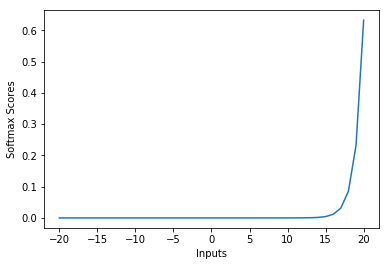

In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def softmax(inputs):
    """
    Calculate the softmax for the give inputs (array)
    :param inputs:
    :return:
    """
    return np.exp(inputs) / float(sum(np.exp(inputs)))


def line_graph(x, y, x_title, y_title):
    """
    Draw line graph with x and y values
    :param x:
    :param y:
    :param x_title:
    :param y_title:
    :return:
    """
    plt.plot(x, y)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.show()


graph_x = range(-20, 21)
graph_y = softmax(graph_x)

print("Graph X readings: {}".format(graph_x))
print("Graph Y readings: {}".format(graph_y))

line_graph(graph_x, graph_y, "Inputs", "Softmax Scores")

### Cross-entropy (Negative log likelihood)

If our network outputs are probabilities, the cross-entropy loss represents the negative log likelihood of the observed data, which means that minimizing that loss is the same as maximizing the log likelihood (and hence the likelihood) of the training data.

<img src="images/neural_networks6.png" alt="" style="width: 600px;"/>

From: [Cross entropy function (python)](https://stackoverflow.com/questions/47377222/cross-entropy-function-python)

In [62]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [63]:
predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.96]])
targets = np.array([[0,0,0,1],
                   [0,0,0,1]])
ans = 0.71355817782  #Correct answer
x = cross_entropy(predictions, targets)
print(np.isclose(x, ans))

True


## Resources

- [Difference between softmax and sigmoid function](http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/)